<a href="https://colab.research.google.com/github/toastmaker/ml4a/blob/main/notebooks/dummy_flare_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanSquaredError

In [3]:
def fred(t, tp, A, sr, sd, nu=2, norm='nphot'):
	"""
	Creates a flare, normalised by the total number of
	counts (norm='nphot) or peak height (norm='peak')
	
	exp( -| t - tp |^nu / sigma)
	
	where
	sigma = sr if t < tp
	or
	sigma = sd if t > tp 
	"""
	sigma = np.where(t < tp, sr, sd)
	s = np.exp( -np.abs(t - tp)**nu / sigma )
	if norm=="nphot":
		ind = ( (tp-t) < sr) & ( (t-tp) < sd)
		s = A*s/np.sum(s[ind])
	elif norm=="peak":
		s = A*s
	return s

Text(0.5, 1.0, '1')

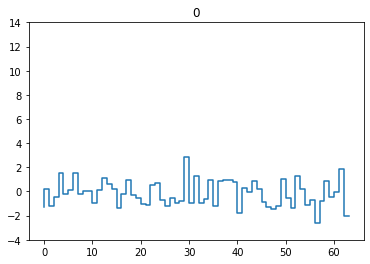

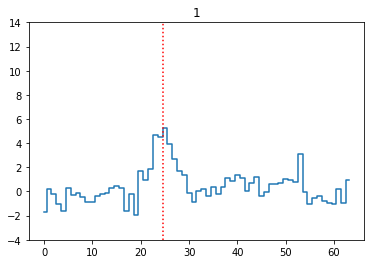

In [6]:
def rnd(low, high, size=1):
  return (high-low)*np.random.random(size=size) + low

T = 64
N = 10000
M = 100
t = np.arange(T)
tps = np.zeros(N)
X = np.random.normal(0, 1, size=(N,T))
y = np.zeros(N, dtype=np.int)
for i in np.arange(N-M, N):
  A = rnd(3,8)
  tp = rnd(20,T-20)
  X[i,:] += fred(t, tp, A, 5.,10., norm='peak')
  y[i] = 1
  tps[i] = tp
j = 0

plt.figure()
plt.step(t, X[j,:])
plt.title(y[j])
plt.ylim((-4,14))

k = N-1
plt.figure()
plt.step(t,X[k,:], where='mid')
plt.axvline(tps[k], linestyle=":", color="r")
plt.ylim((-4,14))
plt.title(y[k])

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X[:N-M,:], y[:N-M], test_size=0.2) #, stratify=y[:N-M])

In [29]:
# min_max_scaler = MinMaxScaler(feature_range=(0, 1))
# x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
# x_test_scaled = min_max_scaler.transform(x_test.copy())
# x_train_scaled = x_train.copy()
# x_test_scaled = x_test.copy()

In [9]:
class AutoEncoder(Model):
  def __init__(self, output_units, latent=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(latent, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

In [30]:
model = AutoEncoder(output_units=x_train.shape[1], latent=8)
model.compile(loss='mse', metrics=['mse'], optimizer='adam')

In [31]:
history = model.fit(x_train, x_train,
    epochs=100, batch_size=100,
    validation_data=(x_test, x_test),
    verbose=0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend(['loss', 'val_loss'])

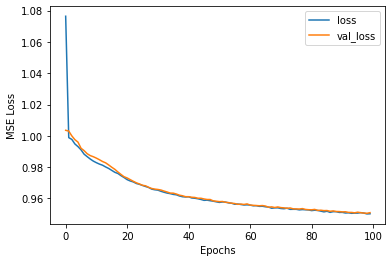

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend(['loss', 'val_loss'])

(1, 64)


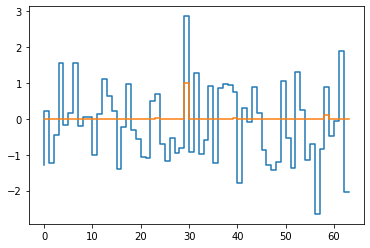

In [33]:
j = 0
XX = X[j:j+1,:]
print(XX.shape)
pred = model.predict(XX)
plt.step(t, XX[0,:])
plt.step(t, pred[0,:])

(1, 64)


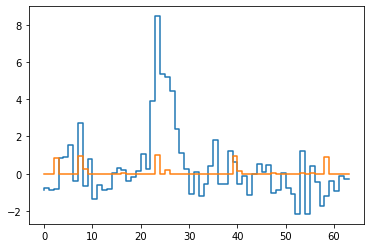

In [34]:
j = -2
XX = X[j:j+1,:]
print(XX.shape)
pred = model.predict(XX)
plt.step(t, XX[0,:])
plt.step(t, pred[0,:])

In [35]:
def find_threshold(model, x, nsigma=1):
  reconstructions = model.predict(x)
  reconstruction_errors = tf.keras.losses.mse(reconstructions, x)
  threshold = np.mean(reconstruction_errors.numpy()) \
      + nsigma*np.std(reconstruction_errors.numpy())
  return threshold

def find_threshold_method_two(model, x):
  reconstructions = model.predict(x)
  reconstruction_errors = tf.keras.losses.mse(reconstructions, x)
  threshold_2 = np.percentile(reconstruction_errors, 95)
  return threshold_2

def get_predictions(model, x, threshold):
  predictions = model.predict(x)
  errors = tf.keras.losses.mse(predictions, x)
  preds = np.where(errors > threshold, 1, 0 )
  return preds

In [36]:
# X_scaled = min_max_scaler.fit_transform(X.copy())

threshold = find_threshold(model, X, nsigma=2)
print(f"Threshold method one: {threshold}")

threshold_2 = find_threshold_method_two(model, X)
print(f"Threshold method two: {threshold_2}")


preds = get_predictions(model, X, threshold)
print(accuracy_score(preds, y))

preds = get_predictions(model, X, threshold_2)
print(accuracy_score(preds, y))

Threshold method one: 1.449521210086552
Threshold method two: 1.258165136940287
0.9943
0.9594


In [37]:
def plot_predictions(model,X, y, threshold):
  predictions = model.predict(X)
  errors = tf.keras.losses.mse(predictions, X)
  preds = np.where(errors > threshold, 1, 0 )
  ind0 = y==0
  ind1 = y==1
  dummyx = np.arange(X.shape[0])
  plt.scatter(dummyx[ind1], errors[ind1], color="r", alpha=0.5)
  plt.scatter(dummyx[ind0],errors[ind0], color="b", alpha=0.1)
  plt.axhline(threshold, color="g", linestyle="--")
  return preds

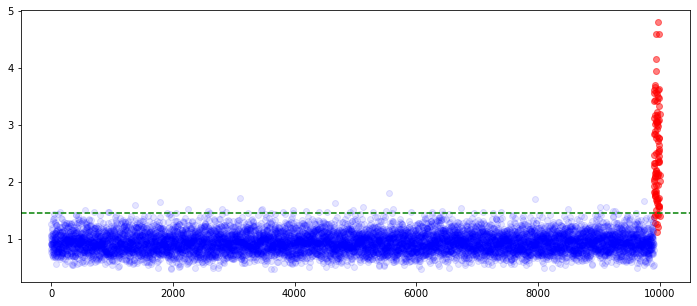

In [38]:
plt.figure(figsize=(12,5))
plot_predictions(model, X, y, threshold);

In [39]:
ind = y==1
preds = get_predictions(model, X[ind], threshold)
print(accuracy_score(preds, y[ind]))

0.91


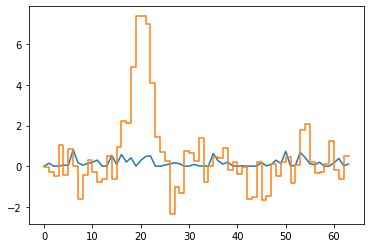

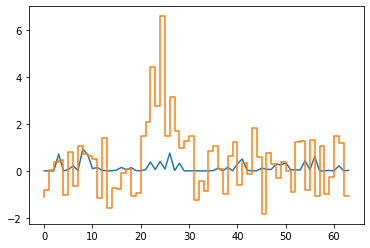

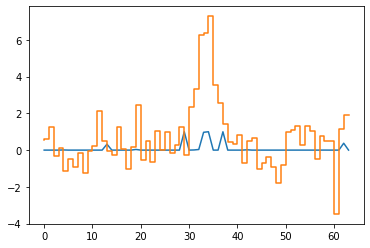

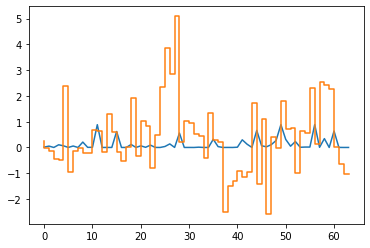

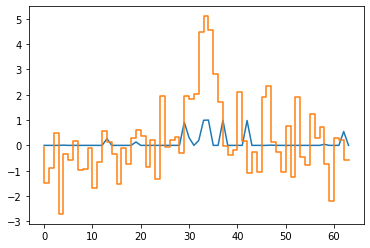

In [40]:
for i in np.arange(N-M,N-M+5):
    plt.figure()
    prediction = model.predict(X[i:i+1,:])
    plt.plot(t, prediction[0,:])
    plt.step(t, X[i,:])

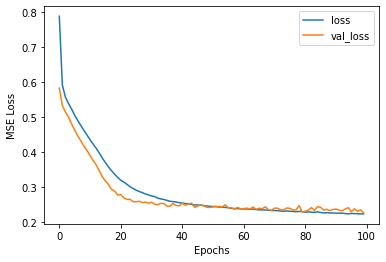

In [52]:
import keras
from keras import layers
latent = 2
model2 = keras.Sequential(
    [
        layers.Input(shape=(T,1)),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=5, padding="same", strides=2, activation="relu"
        ),
        layers.Flatten(),
        layers.Dense(latent, activation='relu'),
        layers.Conv1DTranspose(
            filters=16, kernel_size=5, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model2.compile(loss='mse', metrics=['mse'], optimizer='adam')

history = model2.fit(x_train[:,:,np.newaxis], x_train[:,:,np.newaxis],
    epochs=100, batch_size=100,
    validation_data=(x_test[:,:,np.newaxis], x_test[:,:,np.newaxis]),
    verbose=0)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend(['loss', 'val_loss'])

In [44]:
def find_threshold(model, x, nsigma=1):
  reconstructions = model.predict(x)
  reconstruction_errors = tf.keras.losses.mse(reconstructions.reshape(reconstructions.shape[0:2]), x[:,:,0])
  threshold = np.mean(reconstruction_errors.numpy()) \
      + nsigma*np.std(reconstruction_errors.numpy())
  return threshold

def find_threshold_method_two(model, x):
  reconstructions = model.predict(x)
  reconstruction_errors = tf.keras.losses.mse(reconstructions[:,:,0], x[:,:,0])
  threshold_2 = np.percentile(reconstruction_errors, 95)
  return threshold_2

def get_predictions(model, x, threshold):
  predictions = model.predict(x)
  errors = tf.keras.losses.mse(predictions[:,:,0], x[:,:,0])
  preds = np.where(errors > threshold, 1, 0 )
  return preds

In [53]:
# X_scaled = X.copy() # min_max_scaler.fit_transform(X.copy())

threshold = find_threshold(model2, X[:,:,np.newaxis], nsigma=2)
print(f"Threshold method one: {threshold}")

threshold_2 = find_threshold_method_two(model2, X[:,:,np.newaxis])
print(f"Threshold method two: {threshold_2}")


preds = get_predictions(model2, X[:,:,np.newaxis], threshold)
print(accuracy_score(preds, y))

preds = get_predictions(model2, X[:,:,np.newaxis], threshold_2)
print(accuracy_score(preds, y))

Threshold method one: 0.45630120805826113
Threshold method two: 0.3520788233008934
0.9952
0.96


In [54]:
def plot_predictions(model, X, y, threshold):
  predictions = model.predict(X)
  errors = tf.keras.losses.mse(predictions[:,:,0], X[:,:,0])
  preds = np.where(errors > threshold, 1, 0 )
  ind0 = y==0
  ind1 = y==1
  dummyx = np.arange(X.shape[0])
  plt.scatter(dummyx[ind1], errors[ind1], color="r", alpha=0.5)
  plt.scatter(dummyx[ind0],errors[ind0], color="b", alpha=0.1)
  plt.axhline(threshold, color="g", linestyle="--")
  return preds

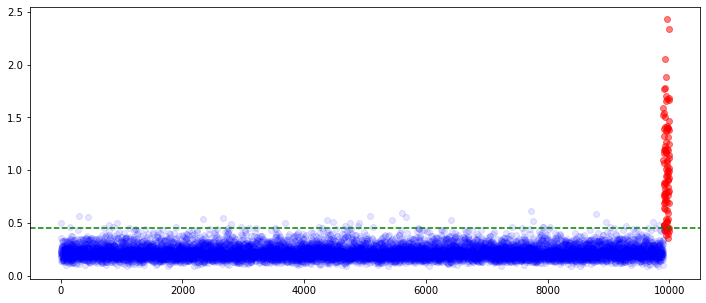

In [55]:
plt.figure(figsize=(12,5))
plot_predictions(model2, X[:,:,np.newaxis], y, threshold);

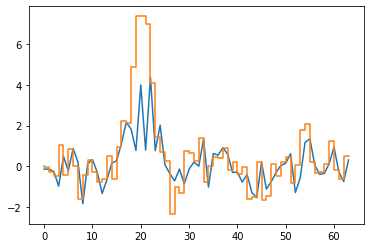

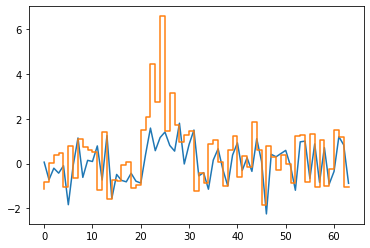

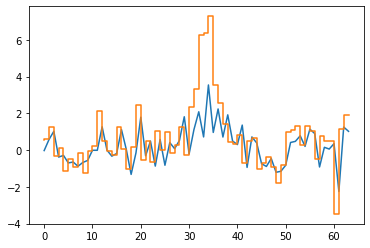

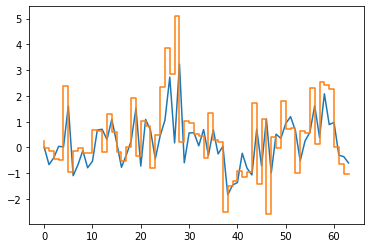

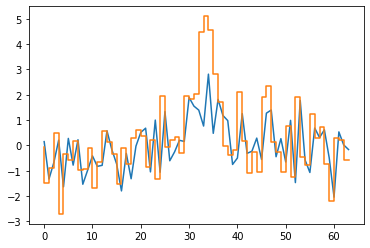

In [56]:
for i in np.arange(N-M,N-M+5):
    plt.figure()
    prediction = model2.predict(X[i:i+1,:,np.newaxis])
    plt.plot(t, prediction[0,:, 0])
    plt.step(t, X[i,:])